# Passo 1. Configuração do projeto

In [1]:
import joblib
import os

import matplotlib 
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns 

import sklearn 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

print('Matplot version: {}'.format(matplotlib.__version__))
print('Numpy version  : {}'.format(np.__version__))
print('Pandas version : {}'.format(pd.__version__))
print('Sklearn version: {}'.format(sklearn.__version__))
print('Seaborn version: {}'.format(sns.__version__))


DATA_PATH = os.path.join('..', 'data', 'raw')
DATA_FILE = 'crx.data'
DIABETES_DATA = os.path.join(DATA_PATH, DATA_FILE)

DEPLOY_PATH = os.path.join('..', 'model')
DEPLOY_FILE = 'finalized_model.sav'

RANDOM_STATE = 42

print('Configuração completa')


Matplot version: 3.3.2
Numpy version  : 1.19.2
Pandas version : 1.1.3
Sklearn version: 0.23.2
Seaborn version: 0.11.0
Configuração completa


# Passo 2. Carga de dados

In [2]:
def load_data(data_path, data_file):
    local_path = os.path.join(data_path, data_file)
    return pd.read_csv(local_path, header=None, names=['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12','A13',
                                                       'A14','A15','A16'])
    

In [3]:
credit_data = load_data(DATA_PATH, DATA_FILE)

# Passo 3. Análise exploratória de dados

In [4]:
print('Credit dataset tem {} linhas e {} colunas'.format(credit_data.shape[0], credit_data.shape[1]))

Credit dataset tem 690 linhas e 16 colunas


In [5]:
credit_data.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


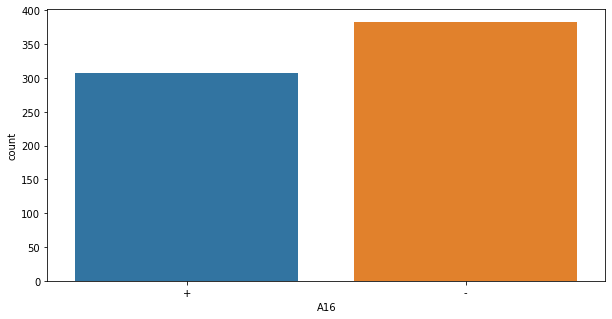

In [6]:
plt.figure(figsize=(10, 5))
_ = sns.countplot(x='A16', data=credit_data)

## Verificando valores nulos (NA)

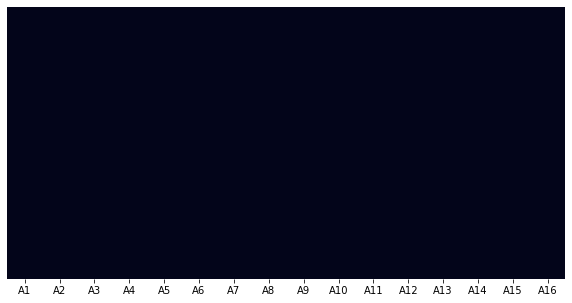

In [7]:
plt.figure(figsize=(10,5))
_ = sns.heatmap(credit_data.isnull(), yticklabels=False, cbar=False)

## Correlação e distribuição dos dados

In [8]:
X = credit_data.drop(['A16'], axis=1)
y = credit_data['A16']

In [10]:
#_ = pd.plotting.scatter_matrix(X, c=y, figsize=[10,10], marker='D')

# Passo 4. Preparação de dados

## 4.1 Amostragem aleatória

credit_amostra = credit_data.groupby('class', group_keys=False).apply(
    lambda x: x.sample(min(len(x), 4), random_state=42)
)
credit_amostra = credit_amostra.reset_index(drop=True)
credit_amostra

## 4.2 Tratamento de dados ausentes

### Identificação de dados ausentes

In [11]:
credit_data.tail(10)

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
680,b,19.50,0.290,u,g,k,v,0.290,f,f,0,f,g,00280,364,-
681,b,27.83,1.000,y,p,d,h,3.000,f,f,0,f,g,00176,537,-
682,b,17.08,3.290,u,g,i,v,0.335,f,f,0,t,g,00140,2,-
683,b,36.42,0.750,y,p,d,v,0.585,f,f,0,f,g,00240,3,-
684,b,40.58,3.290,u,g,m,v,3.500,f,f,0,t,s,00400,0,-
685,b,21.08,10.085,y,p,e,h,1.250,f,f,0,f,g,00260,0,-
686,a,22.67,0.750,u,g,c,v,2.000,f,t,2,t,g,00200,394,-
687,a,25.25,13.500,y,p,ff,ff,2.000,f,t,1,t,g,00200,1,-
688,b,17.92,0.205,u,g,aa,v,0.040,f,f,0,f,g,00280,750,-
689,b,35.00,3.375,u,g,c,h,8.290,f,f,0,t,g,00000,0,-


In [21]:
num_ausentes = (credit_data[['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12','A13','A14','A15','A16']] == 0).sum()
print('Quantidade de dados ausentes:\n{}'.format(num_ausentes))

Quantidade de dados ausentes:
A1       0
A2       0
A3       0
A4       0
A5       0
A6       0
A7       0
A8       0
A9       0
A10      0
A11    395
A12      0
A13      0
A14      0
A15      0
A16      0
dtype: int64


In [13]:
credit_data[['A2','A3','A8','A14','A15']] =credit_data[
    ['A2','A3','A8','A14','A15']].replace(0, np.nan)
credit_data.isnull().sum()

A1       0
A2       0
A3      19
A4       0
A5       0
A6       0
A7       0
A8      70
A9       0
A10      0
A11      0
A12      0
A13      0
A14      0
A15    295
A16      0
dtype: int64

In [14]:
for c in range(credit_data.shape[1]):
    ausentes   = credit_data[[credit_data.columns[c]]].isnull().sum()
    percentual = ausentes / credit_data.shape[0] * 100
    print ("> %s, ausentes: %d (%.2f%%)" % (credit_data.columns[c], ausentes, percentual) )

> A1, ausentes: 0 (0.00%)
> A2, ausentes: 0 (0.00%)
> A3, ausentes: 19 (2.75%)
> A4, ausentes: 0 (0.00%)
> A5, ausentes: 0 (0.00%)
> A6, ausentes: 0 (0.00%)
> A7, ausentes: 0 (0.00%)
> A8, ausentes: 70 (10.14%)
> A9, ausentes: 0 (0.00%)
> A10, ausentes: 0 (0.00%)
> A11, ausentes: 0 (0.00%)
> A12, ausentes: 0 (0.00%)
> A13, ausentes: 0 (0.00%)
> A14, ausentes: 0 (0.00%)
> A15, ausentes: 295 (42.75%)
> A16, ausentes: 0 (0.00%)


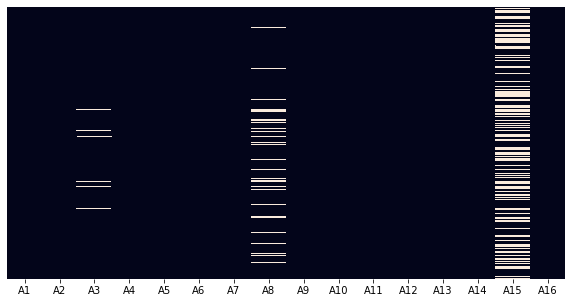

In [15]:
plt.figure(figsize=(10,5))
_ = sns.heatmap(credit_data.isnull(), yticklabels=False, cbar=False)

### Remocao e Imputação de dados ausentes


In [16]:
#wine_data.drop(['class'], axis=1, inplace=True)

In [22]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
credit_data[['A2','A3','A8','A14','A15']] = imputer.fit_transform(
    credit_data[['A2','A3','A8','A14','A15']].values
)

ValueError: Cannot use mean strategy with non-numeric data:
could not convert string to float: '?'

In [18]:
credit_data.describe()

,A3,A8,A11,A15
count,671.000000,620.000000,690.00000,395.000000
mean,4.893472,2.474435,2.40000,1777.205063
std,4.982421,3.441432,4.86294,6790.862630
min,0.040000,0.040000,0.00000,1.000000
25%,1.105000,0.290000,0.00000,21.500000
50%,3.000000,1.250000,0.00000,286.000000
75%,7.520000,3.040000,3.00000,1063.500000
max,28.000000,28.500000,67.00000,100000.000000


## Passo 5. Transformação de dados

In [19]:
from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import StandardScaler

X = credit_data.drop(['A16'], axis=1)
y = credit_data['A16']

scaler = MinMaxScaler() 
X_scaled = pd.DataFrame(scaler.fit_transform(X))
X_scaled.columns = X.columns

#scaler = StandardScaler() 
#X_scaled = pd.DataFrame(scaler.fit_transform(X))
#X_scaled.columns = X.columns

ValueError: could not convert string to float: 'b'

In [ ]:
X_scaled.head()

# Passo 6. Particionamento do dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=.3, random_state=RANDOM_STATE)

# Passo 7. Treinamento do modelo

## 7.1 K-NN

In [ ]:
neighbors = np.arange(1, 50)
train_acc = np.empty(len(neighbors))
test_acc  = np.empty(len(neighbors))
for i, k in enumerate(neighbors):
    clf = KNeighborsClassifier(n_neighbors=k) 
    clf.fit(X_train, y_train) 
    train_acc[i] = clf.score(X_train, y_train)
    test_acc[i]  = clf.score(X_test, y_test)

plt.figure(figsize=(10,5))
plt.title('Acurácia por quantidade de vizinhos')
plt.plot(neighbors, train_acc, label='Treinamento')
plt.plot(neighbors, test_acc, label='Test')
plt.xticks(np.arange(min(neighbors), max(neighbors)+1, 2))
plt.legend()
plt.xlabel('Quantide de vizinhos')
plt.ylabel('Acuracia')
plt.show()

In [ ]:
knn = KNeighborsClassifier(n_neighbors=13) 
knn.fit(X_train, y_train)

In [ ]:
resultados_cv = cross_val_score(knn, X_train, y_train, cv=5)
print('Resultados do cross-validation em treinamento:\n', resultados_cv)

In [ ]:
print('Médias dos resultados do cross-validation em treinamento:\n', np.mean(resultados_cv))

In [ ]:
knn_padrao = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 50)}
knn_cv = GridSearchCV(knn_padrao, param_grid, cv=5)
knn_cv.fit(X_train, y_train)

In [ ]:
print('Quantidade de vizinhos: {}'.format(knn_cv.best_params_))

In [ ]:
print('Melhor resultado com {} foi de {}'.format(knn_cv.best_params_, knn_cv.best_score_))

## 7.2 Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print('Acurária do Logistic Regression com Defaults: {}'. format(logreg.score(X_test, y_test)))

In [ ]:
params = {"C": [100, 1.0, 0.1, 0.01], "penalty": ["none", "l1", "l2"]}
logreg_cv = GridSearchCV(logreg, params, cv=5)
logreg_cv.fit(X_train, y_train)

In [ ]:
print('Acurária do Logistic Regression com GridSearch: {}'. format(logreg_cv.score(X_test, y_test)))

# Passo 8. Teste do modelo

In [ ]:
#y_pred = knn.predict(X_test)
y_pred = knn_cv.predict(X_test)
print('Prediçoes em teste:\n{}'.format(y_pred))

# Passo 9. Avaliação do modelo

In [ ]:
# Acurária com 5 vizinhos: 0.7186147186147186
print('Acurácia do modelo: {}'.format(knn_cv.score(X_test, y_test)))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 5))
_  = sns.heatmap(cm, annot=True, cbar=False, fmt='d')

In [ ]:
print('Precisão, revogação e f1-score:')
print(classification_report(y_test, y_pred))